In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
!pip install torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    print(f"Train -- Avg loss: {train_loss:>7f}, Accuracy: {(100*correct):>0.1f}%")
    return train_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test  -- Avg loss: {test_loss:>7f}, Accuracy: {(100*correct):>0.1f}%")
    return test_loss, correct

In [10]:
epochs = 10
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for t in range(epochs):
    print(f"--- Epoch {t+1} ---")
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(test_dataloader, model, loss_fn)
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['test_loss'].append(test_loss)
    history['test_acc'].append(test_acc)
    
print("\nTraining Complete!")

--- Epoch 1 ---
Train -- Avg loss: 0.522633, Accuracy: 81.3%
Test  -- Avg loss: 0.441357, Accuracy: 83.8%
--- Epoch 2 ---
Train -- Avg loss: 0.369414, Accuracy: 86.6%
Test  -- Avg loss: 0.384861, Accuracy: 85.9%
--- Epoch 3 ---
Train -- Avg loss: 0.330563, Accuracy: 87.8%
Test  -- Avg loss: 0.371846, Accuracy: 86.5%
--- Epoch 4 ---
Train -- Avg loss: 0.306931, Accuracy: 88.5%
Test  -- Avg loss: 0.374746, Accuracy: 86.9%
--- Epoch 5 ---
Train -- Avg loss: 0.288347, Accuracy: 89.2%
Test  -- Avg loss: 0.332556, Accuracy: 88.2%
--- Epoch 6 ---
Train -- Avg loss: 0.274140, Accuracy: 89.7%
Test  -- Avg loss: 0.349263, Accuracy: 87.1%
--- Epoch 7 ---
Train -- Avg loss: 0.259395, Accuracy: 90.4%
Test  -- Avg loss: 0.337966, Accuracy: 87.9%
--- Epoch 8 ---
Train -- Avg loss: 0.247175, Accuracy: 90.7%
Test  -- Avg loss: 0.348874, Accuracy: 87.2%
--- Epoch 9 ---
Train -- Avg loss: 0.237951, Accuracy: 91.0%
Test  -- Avg loss: 0.331758, Accuracy: 88.7%
--- Epoch 10 ---
Train -- Avg loss: 0.226872, 

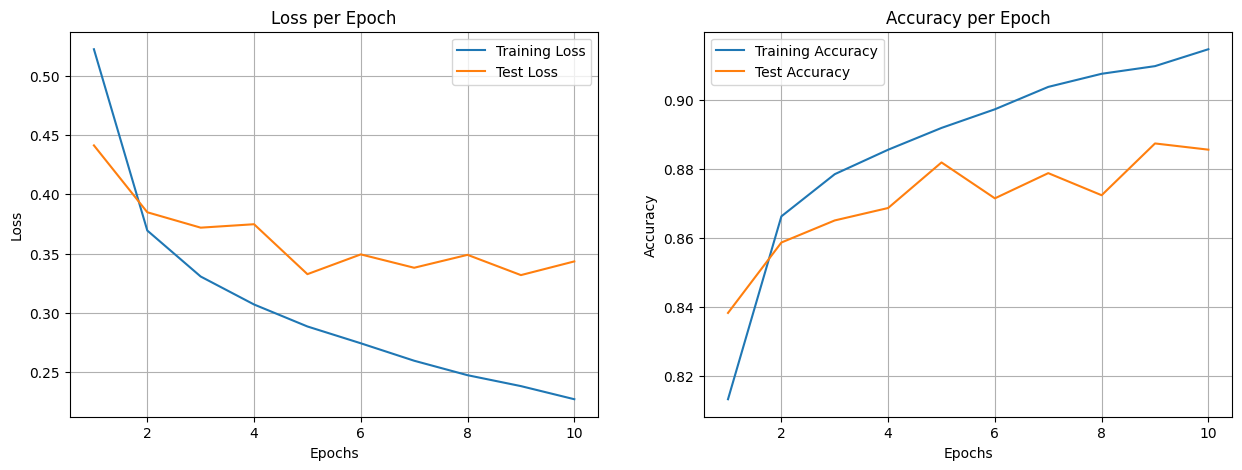

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and test loss
ax1.plot(range(1, epochs + 1), history['train_loss'], label='Training Loss')
ax1.plot(range(1, epochs + 1), history['test_loss'], label='Test Loss')
ax1.set_title('Loss per Epoch')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plotting training and test accuracy
ax2.plot(range(1, epochs + 1), history['train_acc'], label='Training Accuracy')
ax2.plot(range(1, epochs + 1), history['test_acc'], label='Test Accuracy')
ax2.set_title('Accuracy per Epoch')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.show()

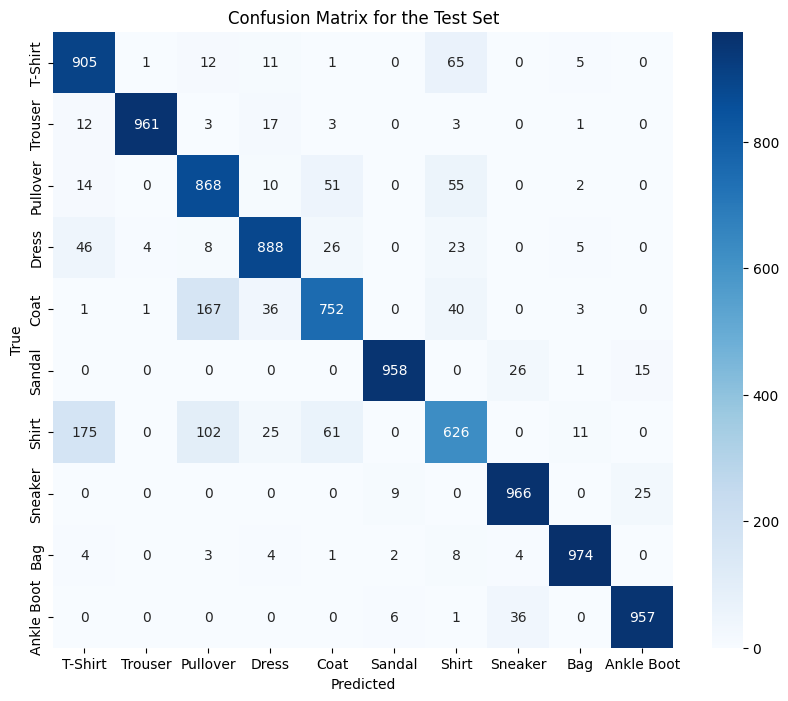

In [16]:
y_pred = []
y_true = []


labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Build the confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for the Test Set')
plt.show()

--- Correct Predictions ---
--- Incorrect Predictions ---


<Figure size 1500x1500 with 0 Axes>

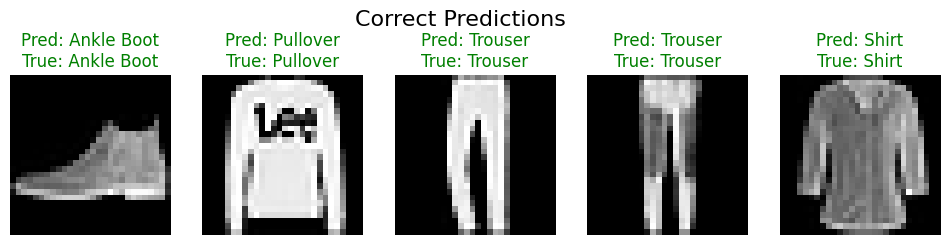

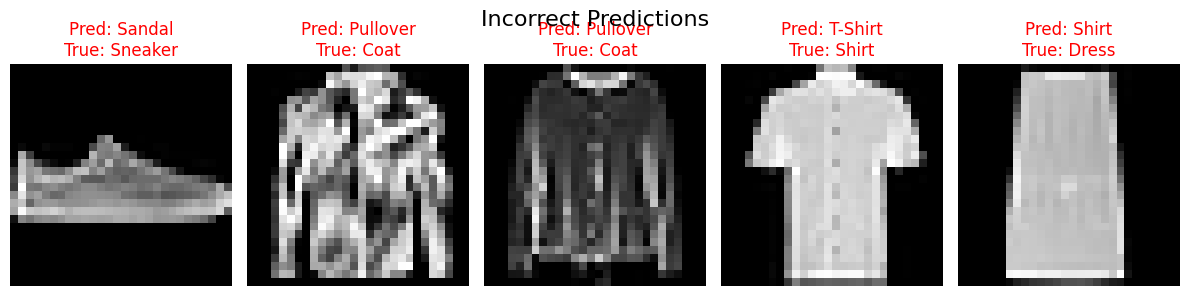

In [17]:
def visualize_predictions(dataset, num_images=10):
    plt.figure(figsize=(15, 15))
    model.eval()
    correct_count = 0
    incorrect_count = 0

    print("--- Correct Predictions ---")
    fig1, axes1 = plt.subplots(1, 5, figsize=(12, 3))
    fig1.suptitle('Correct Predictions', fontsize=16)

    print("--- Incorrect Predictions ---")
    fig2, axes2 = plt.subplots(1, 5, figsize=(12, 3))
    fig2.suptitle('Incorrect Predictions', fontsize=16)

    with torch.no_grad():
        for i in range(len(dataset)):
            if correct_count >= 5 and incorrect_count >= 5:
                break

            image, label = dataset[i]
            image_gpu = image.unsqueeze(0).to(device)
            
            output = model(image_gpu)
            _, pred = torch.max(output, 1)
            predicted_label = pred.item()
            true_label = label

            is_correct = (predicted_label == true_label)

            if is_correct and correct_count < 5:
                ax = axes1[correct_count]
                ax.imshow(image.squeeze(), cmap="gray")
                ax.set_title(f"Pred: {labels_map[predicted_label]}\nTrue: {labels_map[true_label]}", color='green')
                ax.axis('off')
                correct_count += 1
            elif not is_correct and incorrect_count < 5:
                ax = axes2[incorrect_count]
                ax.imshow(image.squeeze(), cmap="gray")
                ax.set_title(f"Pred: {labels_map[predicted_label]}\nTrue: {labels_map[true_label]}", color='red')
                ax.axis('off')
                incorrect_count += 1
    
    plt.tight_layout()
    plt.show()

visualize_predictions(test_data)

## Conclusion 📝
#### The neural network demonstrates strong performance on the Fashion MNIST dataset, achieving a final test accuracy of 88.5% after 10 epochs of training. The model learned effectively, as evidenced by the consistent decrease in training loss from 0.52 to 0.23 and the increase in training accuracy to 91.5%. However, the slight divergence between the training and test metrics suggests a minor degree of overfitting. The confusion matrix reveals that the model performs well across most classes but has some difficulty distinguishing between similar items, notably confusing "Shirt" with "T-Shirt" and "Pullover." Overall, the model provides a solid baseline for classifying fashion items.
